<a href="https://colab.research.google.com/github/raffieeey/MasterResearchAutoML/blob/master/02A_H2OAutoml_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependecies for H2O automl

In [0]:
!pip install pmlb
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install pytictoc

In [0]:
#!pip uninstall h2o -y

## Installing H2O

In [0]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


## Getting the number of Cores

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits 

##Starting H2O

In [0]:
import h2o

In [0]:
h2o.init(nthreads=2,
                 min_mem_size="2048M",
                 max_mem_size="2048M")

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 56 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.5
H2O cluster version age:,"7 days, 23 hours and 45 minutes"
H2O cluster name:,H2O_from_python_unknownUser_cewu4b
H2O cluster total nodes:,1
H2O cluster free memory:,1.620 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"


## Creating the metrics for AUC and AUCpr (Binary classification)

In [0]:
%matplotlib inline
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np



def get_auc(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def get_aucpr(labels, scores):
    precision, recall, th = precision_recall_curve(labels, scores)
    aucpr_score = np.trapz(recall, precision)
    return precision, recall, aucpr_score


def plot_metric(ax, x, y, x_label, y_label, plot_label, style="-"):
    ax.plot(x, y, style, label=plot_label)
    ax.legend()
    
    ax.set_ylabel(x_label)
    ax.set_xlabel(y_label)


def prediction_summary(labels, predicted_score, info, plot_baseline=True, axes=None):
    if axes is None:
        axes = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]

    fpr, tpr, auc_score = get_auc(labels, predicted_score)
    plot_metric(axes[0], fpr, tpr, "False positive rate","True positive rate", "{} AUC = {:.4f}".format(info, auc_score))
    if plot_baseline:
        plot_metric(axes[0], [0, 1], [0, 1], "False positive rate","True positive rate", "baseline AUC = 0.5", "r--")

    precision, recall, aucpr_score = get_aucpr(labels, predicted_score)
    plot_metric(axes[1], recall, precision, "Recall","Precision", "{} AUCPR = {:.4f}".format(info, aucpr_score))
    if plot_baseline:
        thr = (np.sum(labels)/len(labels))[0]
        plot_metric(axes[1], [0, 1], [thr, thr], "Recall","Precision", "baseline AUCPR = {:.4f}".format(thr), "r--")

    plt.show()
    return axes


def figure():
    fig_size = 4.5
    f = plt.figure()
    f.set_figheight(fig_size)
    f.set_figwidth(fig_size*2)

figure()

<Figure size 648x324 with 0 Axes>

## Creating all the metrics for Classification algorithm

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss
import numpy as np
import pandas as pd


class CheckBinomial:
  def __init__(self, checkunique):
    self._bintype = 'binomial' if pd.Series(checkunique).nunique() == 2 else 'multinomial'

  def MLMetrics(self):
    if self._bintype == 'binomial':
      return ['mean_per_class_error', 'AUC', 'logloss']
    elif self._bintype == 'multinomial':
      return ['mean_per_class_error', 'logloss']

class MetricsCalc:
  def __init__(self, truth, predictions):
    self.truth = truth.as_data_frame()
    self.predictions = predictions
    self._target = predictions.iloc[:,0]
    self._probabmax = np.max(predictions.iloc[:,1:], axis=1)
    self._probab = predictions.iloc[:,1:]
    self._type = 'binomial' if (self.truth.nunique() == 2).bool() else 'multinomial'

  def acc(self):
    return float(accuracy_score(self.truth,self._target))

  def auc(self):
    if self._type == "binomial":
      return float(roc_auc_score(self.truth, self._probabmax))
    elif self._type == "multinomial":
      return np.nan 

  def logloss(self):
    return float(log_loss(self.truth, self._probab))
  
  def cm(self):
    return confusion_matrix(self.truth, self._target)
  
  def f1(self):
    if self._type == "binomial":
      return float(f1_score(self.truth, self._target, average='binary'))
    elif self._type == "multinomial":
      return float(f1_score(self.truth, self._target, average='macro')) 

## Running H2O autoML with 
- 120 seconds
- Seed 69
- 2 Cores
- 2GB memory

- Tested for metrics: 
> - Mean per class error
> - AUC
> - Logloss

- Recorded for metrics: 
> - Mean per class error
> - AUC
> - Logloss
> - F1 score
> - Confusion Metrics

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.860569 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190924_145715,0.923146,0.290389,0.221823,0.301607,0.0909667



xgboost prediction progress: |████████████████████████████████████████████| 100%


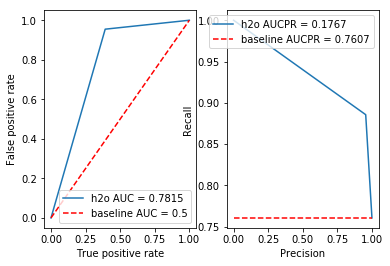

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.904901 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190924_145920,0.92535,0.283764,0.218752,0.299631,0.0897787



xgboost prediction progress: |████████████████████████████████████████████| 100%


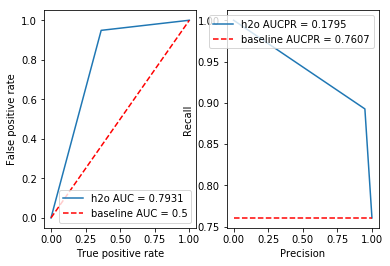

________________________________________________________________________________
*** Dataset Name: adult ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.961485 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190924_150125,0.925427,0.283603,0.213986,0.29956,0.0897362



xgboost prediction progress: |████████████████████████████████████████████| 100%


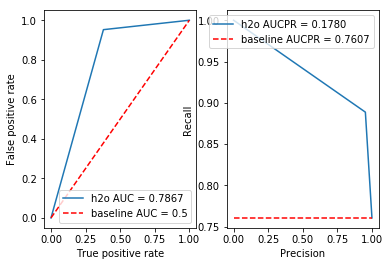

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 125.004840 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_2_AutoML_20190924_150329,1,0.0276882,0,0.0312407,0.000975979
StackedEnsemble_BestOfFamily_AutoML_20190924_150329,1,0.0014277,0,0.00228655,5.22832e-06
GBM_4_AutoML_20190924_150329,1,0.0197564,0,0.0218162,0.000475945
GBM_5_AutoML_20190924_150329,1,0.00569167,0,0.0177184,0.000313941
XGBoost_grid_1_AutoML_20190924_150329_model_1,1,0.0352836,0,0.0506796,0.00256843



gbm prediction progress: |████████████████████████████████████████████████| 100%


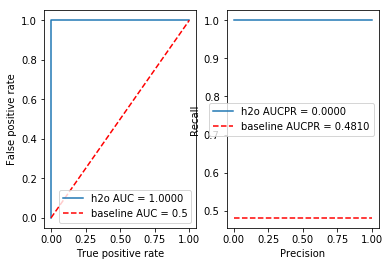

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 124.054353 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190924_150536,1,0.00548786,0,0.0165363,0.00027345
StackedEnsemble_AllModels_AutoML_20190924_150536,1,0.00307494,0,0.0123837,0.000153356
StackedEnsemble_BestOfFamily_AutoML_20190924_150536,1,0.00418803,0,0.00604214,3.65074e-05
XGBoost_2_AutoML_20190924_150536,0.999999,0.0176381,0.000404656,0.0441611,0.0019502



xgboost prediction progress: |████████████████████████████████████████████| 100%


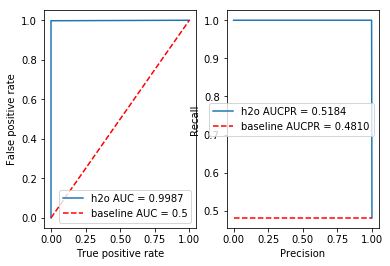

________________________________________________________________________________
*** Dataset Name: agaricus-lepiota ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 123.835889 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190924_150742,1,0.00305679,0,0.0120521,0.000145253
StackedEnsemble_BestOfFamily_AutoML_20190924_150742,1,0.00417655,0,0.00575588,3.31301e-05
XGBoost_1_AutoML_20190924_150742,1,0.00546667,0,0.0163674,0.000267892
XGBoost_2_AutoML_20190924_150742,0.999999,0.0177353,0.000415094,0.0443477,0.00196672



stackedensemble prediction progress: |████████████████████████████████████| 100%


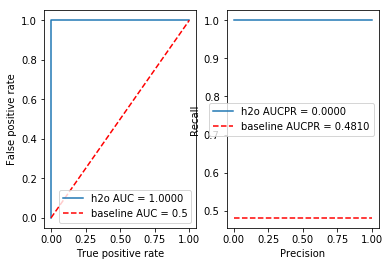

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 126.069403 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_3_AutoML_20190924_150947,0.920028,0.159413,0.0997353,0.192539,0.0370714
GBM_4_AutoML_20190924_150947,0.91989,0.154535,0.101457,0.187801,0.0352691
StackedEnsemble_AllModels_AutoML_20190924_150947,0.915258,0.137677,0.101466,0.180946,0.0327416
StackedEnsemble_BestOfFamily_AutoML_20190924_150947,0.916104,0.13908,0.105666,0.181967,0.0331118
GBM_3_AutoML_20190924_150947,0.924024,0.149247,0.106174,0.186926,0.0349413



xgboost prediction progress: |████████████████████████████████████████████| 100%


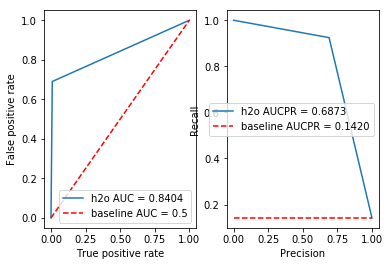

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 126.760364 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_3_AutoML_20190924_151155,0.921822,0.149167,0.0972377,0.186209,0.0346737
GBM_2_AutoML_20190924_151155,0.920925,0.147283,0.101457,0.184037,0.0338697
GBM_1_AutoML_20190924_151155,0.92049,0.14864,0.114204,0.186358,0.0347294
GBM_4_AutoML_20190924_151155,0.919725,0.152925,0.0993569,0.185498,0.0344094
DRF_1_AutoML_20190924_151155,0.917766,0.314764,0.112731,0.206789,0.0427616



gbm prediction progress: |████████████████████████████████████████████████| 100%


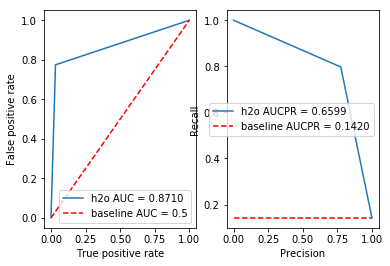

________________________________________________________________________________
*** Dataset Name: churn ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 126.413898 seconds.
*** Top algorithm: *** 

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190924_151404,0.915669,0.136714,0.106203,0.179663,0.0322787
StackedEnsemble_BestOfFamily_AutoML_20190924_151404,0.916532,0.136819,0.103576,0.17996,0.0323856
GBM_2_AutoML_20190924_151404,0.920925,0.147283,0.101457,0.184037,0.0338697
GBM_1_AutoML_20190924_151404,0.92049,0.14864,0.114204,0.186358,0.0347294
GBM_3_AutoML_20190924_151404,0.921822,0.149167,0.0972377,0.186209,0.0346737



stackedensemble prediction progress: |████████████████████████████████████| 100%


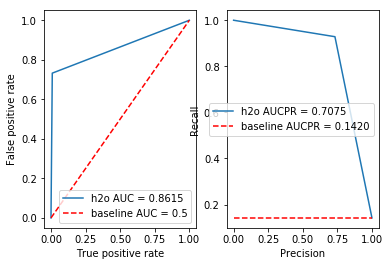

________________________________________________________________________________
*** Dataset Name: nursery ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.955506 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_151612,0.0427412,0.0819547,0.126567,0.0160191



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: nursery ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.878571 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_151815,0.0382363,0.0784837,0.123306,0.0152045



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: nursery ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 122.065891 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_152019,0.0383015,0.0768247,0.121806,0.0148368



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: satimage ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 143.095396 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_152222,0.112655,0.242165,0.272354,0.0741766
StackedEnsemble_AllModels_AutoML_20190924_152222,0.113168,0.273203,0.278139,0.0773614
StackedEnsemble_BestOfFamily_AutoML_20190924_152222,0.113233,0.272624,0.276804,0.0766207
XGBoost_2_AutoML_20190924_152222,0.133446,0.357341,0.328841,0.108136



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: satimage ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.957495 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_152447,0.109822,0.236164,0.26912,0.0724255



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: satimage ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.874672 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_152650,0.109243,0.235863,0.268897,0.0723054



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: texture ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 168.658034 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_AllModels_AutoML_20190924_152854,0.0236364,0.0880915,0.145623,0.0212059
StackedEnsemble_BestOfFamily_AutoML_20190924_152854,0.0242424,0.0896715,0.147024,0.0216161
XGBoost_1_AutoML_20190924_152854,0.0252525,0.10533,0.162246,0.0263238
XGBoost_2_AutoML_20190924_152854,0.0567677,0.83232,0.553814,0.30671



stackedensemble prediction progress: |████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: texture ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.765565 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_153144,0.0248485,0.102886,0.160478,0.0257533



xgboost prediction progress: |████████████████████████████████████████████| 100%
________________________________________________________________________________
*** Dataset Name: texture ***
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Elapsed time is 121.833261 seconds.
*** Top algorithm: *** 

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_153347,0.0250505,0.103416,0.160859,0.0258755



xgboost prediction progress: |████████████████████████████████████████████| 100%


In [0]:
from pmlb import classification_dataset_names, regression_dataset_names,fetch_data
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from pytictoc import TicToc


preds = {}
auc_preds = {}
acc_preds = {}
log_preds = {}
cm_preds = {}
f1_preds = {}
top_algo = {}
t = TicToc()


sel_clss_dtst = ['adult','agaricus-lepiota', 'churn', 'nursery', 'satimage','texture']
sel_rgrs_dtst = ['294_satellite_image','218_house_8L', '227_cpu_small', '503_wind', '344_mv','215_2dplanes']

for class_dtst in sel_clss_dtst:
  for metrics_test in ['mean_per_class_error', 'AUC', 'logloss']:
        print("_"*80)
        print(f"*** Dataset Name: {class_dtst} ***")
        X, y = fetch_data(class_dtst, return_X_y=True)
        c=CheckBinomial(y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=69, stratify=y)
        X_train = h2o.H2OFrame(X_train)
        X_test = h2o.H2OFrame(X_test)
        y_train = h2o.H2OFrame(y_train).asfactor()
        y_test = h2o.H2OFrame(y_test).asfactor()
        list_metrics = c.MLMetrics()
        aml = H2OAutoML(seed=69, max_runtime_secs=120,sort_metric=metrics_test if metrics_test in list_metrics else None)
        t.tic()
        aml.train(x=X_train.columns, y=X_train.cbind(y_train)[:,-1].columns[0], training_frame=X_train.cbind(y_train))
        t.toc()    
        lb = aml.leaderboard
        top_algo[class_dtst] = lb.head(5)
        print("*** Top algorithm: ***", lb.head(5))
        preds[class_dtst] = aml.leader.predict(X_test).as_data_frame()
        p = MetricsCalc(y_test,preds[class_dtst])
        if c._bintype == "binomial":
          auc_preds[class_dtst] = p.auc()
          acc_preds[class_dtst] = p.acc()
          log_preds[class_dtst] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          f1_preds[class_dtst] = p.f1()
          prediction_summary( y_test.as_data_frame(), preds[class_dtst].iloc[:,0], "h2o")
        elif c._bintype == "multinomial":
          acc_preds[class_dtst] = p.acc()
          log_preds[class_dtst] = p.logloss()
          cm_preds[class_dtst] = p.cm()
          f1_preds[class_dtst] = p.f1()

## Looking at the predictions

In [0]:
for i, val in enumerate(preds):
  print(preds[val])

      predict        p0        p1
0           1  0.012280  0.987720
1           1  0.459342  0.540658
2           0  0.991891  0.008109
3           1  0.005298  0.994702
4           0  0.986920  0.013080
5           1  0.021513  0.978487
6           1  0.007122  0.992878
7           1  0.062034  0.937966
8           1  0.028168  0.971832
9           1  0.020400  0.979600
10          1  0.432165  0.567835
11          1  0.098851  0.901149
12          1  0.450483  0.549517
13          1  0.016101  0.983899
14          1  0.440736  0.559264
15          1  0.005915  0.994085
16          1  0.130246  0.869754
17          1  0.252730  0.747270
18          1  0.026730  0.973270
19          1  0.225238  0.774762
20          1  0.316445  0.683555
21          0  0.986181  0.013819
22          0  0.765557  0.234443
23          0  0.505974  0.494026
24          1  0.167111  0.832889
25          1  0.173166  0.826834
26          1  0.051029  0.948971
27          1  0.105806  0.894194
28          1 

## Saving the predictions

In [0]:
for i, val in enumerate(preds):
  preds[val].to_csv(f"{val}.csv")

## Looking at the AUC

In [0]:
auc_preds

{'adult': 0.7229667606199257,
 'agaricus-lepiota': 0.9304409707145269,
 'churn': 0.5109163137332151}

## Looking at the mean per class error

In [0]:
acc_preds

{'adult': 0.8730808597748209,
 'agaricus-lepiota': 1.0,
 'churn': 0.954,
 'nursery': 0.9868827160493827,
 'satimage': 0.9254658385093167,
 'texture': 0.9709090909090909}

## Looking at the logloss

In [0]:
log_preds 

{'adult': 0.2831267640789399,
 'agaricus-lepiota': 0.0022438681568249562,
 'churn': 0.1629397796280997,
 'nursery': 0.06983445570445292,
 'satimage': 0.19901229525743525,
 'texture': 0.10517689601330076}

## Looking at the F1 score

In [0]:
f1_preds

{'adult': 0.919459599896077,
 'agaricus-lepiota': 1.0,
 'churn': 0.8188976377952756,
 'nursery': 0.9708319505727816,
 'satimage': 0.910897014500192,
 'texture': 0.9706980992581422}

## Looking at the confusion matrix

In [0]:
import pprint
pprint.pprint(cm_preds)

{'adult': array([[ 726,  443],
       [ 177, 3539]]),
 'agaricus-lepiota': array([[423,   0],
       [  0, 392]]),
 'churn': array([[425,   4],
       [ 19,  52]]),
 'nursery': array([[432,   0,   0,   0],
       [  0, 415,  12,   0],
       [  0,   0, 404,   0],
       [  0,   5,   0,  28]]),
 'satimage': array([[150,   0,   1,   0,   2,   0],
       [  0,  69,   0,   0,   1,   0],
       [  1,   0, 130,   3,   0,   2],
       [  0,   0,  12,  43,   0,   8],
       [  4,   1,   0,   0,  61,   5],
       [  0,   0,   3,   5,   0, 143]]),
 'texture': array([[44,  1,  0,  0,  0,  1,  4,  0,  0,  0,  0],
       [ 0, 49,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 50,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 50,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 45,  0,  3,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  2, 48,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 50,  0,  0,  0],
       [ 0,  0,  0, 

## Looking at the top algorithm used by the AutoML

In [0]:
top_algo

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190924_150125,0.925427,0.283603,0.213986,0.29956,0.0897362


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190924_150742,1,0.00305679,0,0.0120521,0.000145253
StackedEnsemble_BestOfFamily_AutoML_20190924_150742,1,0.00417655,0,0.00575588,3.31301e-05
XGBoost_1_AutoML_20190924_150742,1,0.00546667,0,0.0163674,0.000267892
XGBoost_2_AutoML_20190924_150742,0.999999,0.0177353,0.000415094,0.0443477,0.00196672


model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190924_151404,0.915669,0.136714,0.106203,0.179663,0.0322787
StackedEnsemble_BestOfFamily_AutoML_20190924_151404,0.916532,0.136819,0.103576,0.17996,0.0323856
GBM_2_AutoML_20190924_151404,0.920925,0.147283,0.101457,0.184037,0.0338697
GBM_1_AutoML_20190924_151404,0.92049,0.14864,0.114204,0.186358,0.0347294
GBM_3_AutoML_20190924_151404,0.921822,0.149167,0.0972377,0.186209,0.0346737


model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_152019,0.0383015,0.0768247,0.121806,0.0148368


model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_152650,0.109243,0.235863,0.268897,0.0723054


model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_1_AutoML_20190924_153347,0.0250505,0.103416,0.160859,0.0258755


{'adult': ,
 'agaricus-lepiota': ,
 'churn': ,
 'nursery': ,
 'satimage': ,
 'texture': }